# Zero-shot Multi-modal Integration with Pre-trained scGPT-spatial 

#### Dataset: Multi-modal Developing Fetal Lung (Visium/Xenium) ([Quach et al.](https://www.nature.com/articles/s41467-024-50281-5))

In this demo, we will explore the integration of two different types of spatial transcriptomics data modalities—10X Visium and Xenium—using the pre-trained scGPT-spatial model. The goal is to project shared genes between these two datasets and use scGPT-spatial's zero-shot embeddings for integrative clustering. Ideally, cells or spots would cluster according to biological states rather than by sequencing protocol. We will assess the biological conservation performance by comparing the clustering results to major cell-type labels.


✨ To get started, you will need to download the following:

   - [scGPT-spatial pretrained checkpoint](https://figshare.com/articles/software/scGPT-spatial_V1_Model_Weights/28356068?file=52163879) ✅

   - [Processed Developing Fetal Lung dataset](https://figshare.com/articles/dataset/_Evaluation_Processed_Multi-modal_Developing_Fetal_Lung_Data_Subset_Visium_Xenium_/28356116?file=52164002]), featuring a subset of Xenium and Visium data from GW15 ✅

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import warnings
from matplotlib import pyplot as plt

from typing import Dict, Optional, Union
import torch
from tqdm import tqdm
from scipy.sparse import csr_matrix
import scib

sys.path.insert(0, "../")
import scgpt_spatial
from scgpt_spatial.utils import eval_scib_metrics
warnings.filterwarnings("ignore", category=ResourceWarning)

#### Step 1: Load dataset
Note that this demo dataset has been pre-processed and filtered to include only the shared genes between the GW15 Visium and Xenium samples published by Quach et al. Major cell class labels are aligned across Visium and Xenium by grouping the subtype annotations provided by the original authors.

In [2]:
adata = sc.read_h5ad('../data/processed_fetal_lung_visium_xenium.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 3745 × 333
    obs: 'orig.ident', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'cell_type', 'batch', 'batch_id', 'celltype', 'str_batch', 'n_counts'
    var: 'feature_name', 'n_counts'

In [4]:
# Visium data contains stromal cells 
adata[adata.obs['batch_id']=='visium'].shape, adata[adata.obs['batch_id']=='visium'].obs.celltype.unique()

((3159, 333),
 ['Stromal']
 Categories (1, object): ['Stromal'])

In [5]:
# Xenium data contains both stromal and epithelial cells 
adata[adata.obs['batch_id']=='xenium'].shape, adata[adata.obs['batch_id']=='xenium'].obs.celltype.unique()

((586, 333),
 ['Epithelial', 'Stromal']
 Categories (2, object): ['Epithelial', 'Stromal'])

#### Step 2: Run scGPT-spatial zero-shot inference 
Make sure all the downloaded `.json` and `.csv` files are also in the checkpoint folder - not just model weights!

You can simply call the `scgpt_spatial.tasks.embed_data()` function below to generate zero-shot embeddings for cells/spots.

In [6]:
model_dir = '../checkpoints/scGPT_spatial_v1'
gene_col = 'feature_name'
cell_type_col = 'celltype'
batch_id_col = 'batch_id'

In [7]:
ref_embed_adata = scgpt_spatial.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_col, 
    batch_size=64,
    return_new_adata=True,
)
ref_embed_adata.obsm['X'] = ref_embed_adata.X.copy()
ref_embed_adata.obs['batch_id'] = adata.obs['batch_id']

Embedding cells: 100%|██████████| 59/59 [00:03<00:00, 15.84it/s]
/h/chloexq/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:447: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


In [8]:
ref_embed_adata

AnnData object with n_obs × n_vars = 3745 × 512
    obs: 'celltype', 'batch_id'
    obsm: 'X'

#### Step 3: Evaluation and Visualization
We use the wrapper function `eval_scib_metrics()` with [scib](https://github.com/theislab/scib) metrics for biological conservation and batch integration evaluation. Louvain clustering is used to identify cell clusters, which are then compared against cell type/modality labels.

The `AVGBIO` score is calculated as mean of `NMI_cluster/label`, `ARI_cluster/label`, and `ASW_label` for biological conservation, and `AVGBATCH` defined as mean of `ASW_label/batch` and `graph_conn`, in line with [scGPT](https://github.com/bowang-lab/scGPT) evaluation. Higher scores indicate better performance.

In [9]:
result_dict = eval_scib_metrics(ref_embed_adata, batch_key=batch_id_col, label_key=cell_type_col)

/h/chloexq/.local/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


NMI...
ARI...
Silhouette score...
Graph connectivity...


In [10]:
result_dict

{'NMI_cluster/label': 0.9261610264825849,
 'ARI_cluster/label': 0.9725679569001567,
 'ASW_label': 0.6884133219718933,
 'ASW_label/batch': 0.6789001689647508,
 'graph_conn': 0.9970238095238095,
 'avg_bio': 0.862380768451545,
 'avg_batch': 0.8379619892442802}

We visualize scGPT-spatial embeddings in UMAP projections: scGPT-spatial separates epithelial and stromal cells into two distinct clusters, and merges Visium and Xenium data within the stromal cluster.

In [11]:
# UMAP projection
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)

Text(0.5, 1.0, 'AVGBIO (0.8624)')

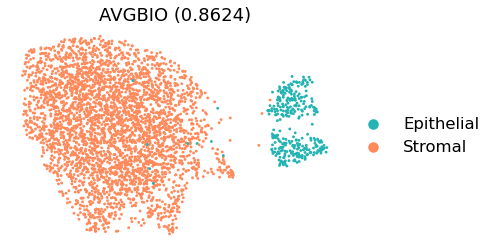

In [12]:
# UMAP visualization with cell labels
custom_palette = ['#23b3b3', '#ff8a5b', '#6aa84f', '#8e44ad', '#f1c40f']
sc.pl.umap(ref_embed_adata, color=cell_type_col, palette=custom_palette, frameon=False, show=False, wspace=0.4)
plt.title('AVGBIO ({:.04f})'.format(result_dict["avg_bio"]))

Text(0.5, 1.0, 'AVGBATCH (0.8380)')

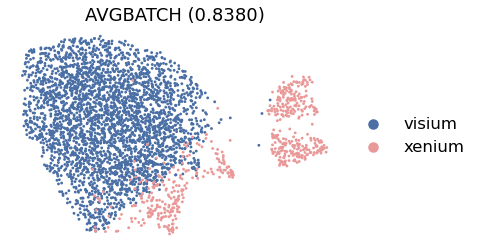

In [13]:
# UMAP visualization with sequencing protocol labels
custom_palette = ['#4a6fa5', '#ea9999', '#9b6bd3','#52c3a3', '#d8c656',  '#6aa84f']
sc.pl.umap(ref_embed_adata, color='batch_id', palette=custom_palette, frameon=False, show=False, wspace=0.4)
plt.title('AVGBATCH ({:.04f})'.format(result_dict["avg_batch"]))